In [1]:
%load_ext autoreload
%autoreload 2
import sys
if "../.." not in sys.path:
    sys.path.append("../..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

from pricing.pricing.models.sig_vol import SigVol
from pricing.pricing.models.stat_sig_vol import StatSigVol
from pricing.pricing.models.model_params import LewisParams, MCParams
from pricing.pricing.products.vanilla_option import VanillaOption
from pricing.pricing.calibration.calibration import Calibration
from pricing.pricing.calibration.calibration_params import CalibrationParams
from pricing.pricing.market_data.market_data_vanilla import MarketDataVanilla
from signature.signature.shuffle import shuffle_product
from signature.signature.characteristic_function import psi_riccati_euler, xi_riccati, psi_riccati_rk4, func_psi
from signature.signature.characteristic_function import psi_riccati_euler_stat, psi_riccati_pece_stat, func_psi_stat
from signature.signature.tensor_algebra import TensorAlgebra
from signature.signature.tensor_sequence import TensorSequence

plt.rcParams["figure.figsize"]        = ((1 + np.sqrt(5)) / 2 * 6, 6)
plt.rcParams["figure.autolayout"]     = True
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams["axes.grid"]             = True

C:\Users\DM6579\Anaconda3\envs\signature\lib\site-packages\py_lets_be_rational\numba_helper.py:10: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  return jit(*jit_args, **jit_kwargs)(fun)


In [2]:
%%time
ta = TensorAlgebra(2, trunc=6)

Compiling...
Compilation finished.
CPU times: total: 7min 58s
Wall time: 13min 32s


In [3]:
N = 3
Ø = ta.from_dict({"": 1}, trunc=N)
_1 = ta.from_dict({"1": 1}, trunc=N)
_2 = ta.from_dict({"2": 1}, trunc=N)
_11 = ta.from_dict({"11": 1}, trunc=N)
_12 = ta.from_dict({"12": 1}, trunc=N)
_21 = ta.from_dict({"21": 1}, trunc=N)
_22 = ta.from_dict({"22": 1}, trunc=N)
_222 = ta.from_word("222", trunc=N)
_221 = ta.from_word("221", trunc=N)
_121 = ta.from_word("121", trunc=N)
_211 = ta.from_word("211", trunc=N)
_2222 = ta.from_word("2222", trunc=N)
_22222 = ta.from_word("22222", trunc=N)

## SigVol and StatSigVol

In [346]:
rho = -0.5

model_sig = SigVol( 
    vol_ts=0.2 * Ø + _2, 
    ta=ta, 
    rho=rho
)

model_stat_sig = StatSigVol( 
    vol_ts=0.2 * Ø + _2 + 5 * _222, 
    ta=ta, 
    rho=rho,
    lam=5
)

61 ms -> 47 ms

In [355]:
%%time
k = np.linspace(-0.1, 0.1, 20)
option = VanillaOption(T=0.1, K=np.exp(k))
iv_sig = option.get_price(model=model_sig, method="lewis", F0=1, is_vol_surface=True, pricing_params=LewisParams(cf_timestep=0.001))

CPU times: total: 625 ms
Wall time: 630 ms


In [350]:
%%time
iv_stat_sig = option.get_price(model=model_stat_sig, method="lewis", F0=1, is_vol_surface=True, pricing_params=LewisParams())

CPU times: total: 3min 59s
Wall time: 4min 9s


## Market Data

In [4]:
df = pd.read_csv("../../pricing/data/implied_volatility/spx_2013-08-14.csv")
maturities = np.sort(df.Expiration.unique())
df

,Expiration,CallPut,ImpliedVolatility,log_moneyness,iv_bid,iv_offer
0,0.024641,P,0.3910,-0.171175,0.376393,0.402286
1,0.024641,P,0.3764,-0.164173,0.362260,0.387329
2,0.024641,P,0.3619,-0.157239,0.348226,0.372473
3,0.024641,P,0.3475,-0.150373,0.334291,0.357719
4,0.024641,P,0.3510,-0.143464,0.342824,0.358056
...,...,...,...,...,...,...
1262,2.346386,C,0.1457,0.250836,0.139175,0.151878
1263,2.346386,C,0.1425,0.297255,0.133663,0.150423
1264,2.346386,C,0.1414,0.319765,0.130852,0.150461
1265,2.346386,C,0.1442,0.425236,0.134989,0.151629


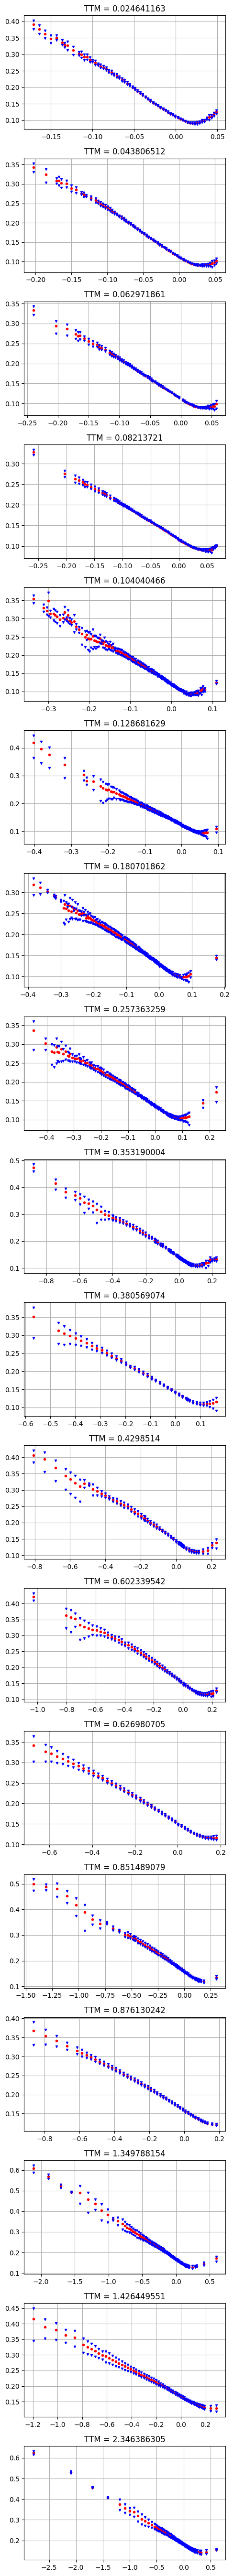

In [5]:
fig, ax_arr = plt.subplots(len(maturities), 1, figsize=(5, len(maturities) * 3))

ms = 3

vanilla_options = []

for ax, T in zip(ax_arr, maturities):
    k = df[df.Expiration == T].log_moneyness
    vanilla_options.append(VanillaOption(T=T, K=np.exp(k)))
    iv = df[df.Expiration == T].ImpliedVolatility
    ax.plot(k, iv, "ro", ms=ms)
    ax.plot(k, df[df.Expiration == T].iv_bid, "bv", ms=ms)
    ax.plot(k, df[df.Expiration == T].iv_offer, "bv", ms=ms)
    ax.set_title(f"TTM = {T}")

In [6]:
N = 3
Ø = ta.from_dict({"": 1}, trunc=N)
_1 = ta.from_dict({"1": 1}, trunc=N)
_2 = ta.from_dict({"2": 1}, trunc=N)
_11 = ta.from_dict({"11": 1}, trunc=N)
_12 = ta.from_dict({"12": 1}, trunc=N)
_21 = ta.from_dict({"21": 1}, trunc=N)
_22 = ta.from_dict({"22": 1}, trunc=N)
_222 = ta.from_word("222", trunc=N)
_221 = ta.from_word("221", trunc=N)
_121 = ta.from_word("121", trunc=N)
_211 = ta.from_word("211", trunc=N)
_2222 = ta.from_word("2222", trunc=N)
_22222 = ta.from_word("22222", trunc=N)

In [7]:
rho = -0.8

model = SigVol( 
    vol_ts=0.2 * Ø, 
    ta=ta, 
    rho=rho
)

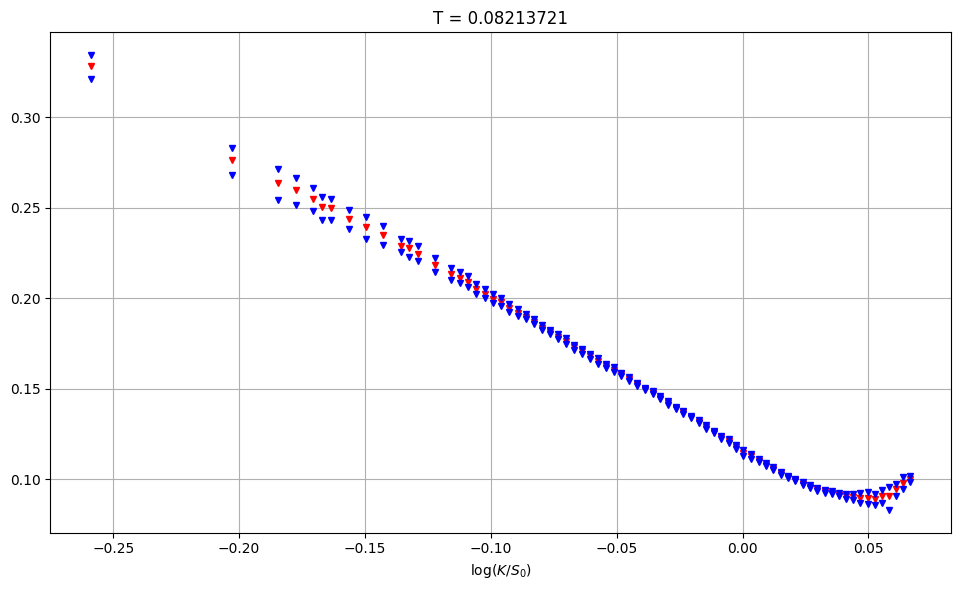

In [8]:
T = maturities[3]
k = df[df.Expiration == T].log_moneyness
vanilla_option = VanillaOption(T=T, K=np.exp(k))
iv = np.array(df[df.Expiration == T].ImpliedVolatility)
md = MarketDataVanilla(
    product=vanilla_option, 
    price=vanilla_option.black_vanilla_price(sigma=iv, F=1, r=0, flag=vanilla_option.flag), 
    implied_volatility=iv
)

ms = 5
plt.plot(k, iv, "rv", ms=ms)
plt.plot(k, df[df.Expiration == T].iv_bid, "bv", ms=ms)
plt.plot(k, df[df.Expiration == T].iv_offer, "bv", ms=ms)
plt.xlabel(r"$\log(K / S_0)$")
plt.title(f"T = {T}")

plt.tight_layout()
plt.savefig("smile_example.pdf", format="pdf", transparent=True)

In [9]:
market_data_array = [md]

In [10]:
# Automatize the construction of vector_to_params
def vector_to_params(x):
    model_params_dict = {
        "rho": x[0],
        "vol_ts": ta.from_array(trunc=model.vol_ts.trunc, array=x[1:])
    }
    return model_params_dict

bounds = [(-1, 0)] + [(-200, 200)] * (2**(N + 1) - 2) + [(0, 200)]

In [11]:
calibration_params = CalibrationParams(
    params_to_calibrate=("vol_ts", "rho"), 
    pricing_params=LewisParams(cf_timestep=0.002, N_points=40, control_variate_sigma=0.13), 
    vector_to_params=vector_to_params, 
    bounds=bounds, 
    optimiser="Differential-evolution"
)

In [12]:
calibration = Calibration(model=model, market_data_array=market_data_array, F0=1, calibration_parameters=calibration_params)

In [625]:
%%time
# x0 = np.array([-0.6] + [0.2] + [0.1] * (2**(N + 1) - 1 - 2) + [10]) 
calibration.loss_iv(x=np.array(x1))

CPU times: total: 281 ms
Wall time: 482 ms


0.0010777066852670828

In [596]:
x0 = np.array([-0.75] + [0] * (2**(N + 1) - 1)) 

l_OU = (Ø * s0 + _1 * lam * theta + _2 * nu).tensor_prod((-lam * _1).shuffle_exp(12))
x0[1 + l_OU.indices] = l_OU.array.real.flatten()
x0[np.abs(x0) > 200] = 200
x0

array([ -0.75,   0.  ,   0.  ,   1.8 ,   0.  ,   0.  , -36.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  , 200.  ,   0.  ,   0.  ,   0.  ])

In [653]:
%%time

calibration.calibrate_model(x0=x3)

Calibrating model parameters...
New iteration: 
 x = [-7.62265311e-01 -2.27446639e-02 -1.66204784e+00  5.92298223e-01
  7.40896000e+01 -1.49809852e+00  5.08207467e+00  1.43250168e+00
 -1.16522626e+02 -1.43819443e+02  4.76231269e+00 -4.01760247e+01
 -1.35222102e+02 -8.29348099e+00 -2.37679841e+01  2.41918589e+00], 
 val=3.44266163729982e-05. 

Convergence = 0.01814056617437565
New iteration: 
 x = [-7.62265311e-01 -2.27446639e-02 -1.66204784e+00  5.92298223e-01
  7.40896000e+01 -1.49809852e+00  5.08207467e+00  1.43250168e+00
 -1.16522626e+02 -1.43819443e+02  4.76231269e+00 -4.01760247e+01
 -1.35222102e+02 -8.29348099e+00 -2.37679841e+01  2.41918589e+00], 
 val=3.44266163729982e-05. 

Convergence = 0.01389753392088621
New iteration: 
 x = [-7.62265311e-01 -2.27446639e-02 -1.66204784e+00  5.92298223e-01
  7.40896000e+01 -1.49809852e+00  5.08207467e+00  1.43250168e+00
 -1.16522626e+02 -1.43819443e+02  4.76231269e+00 -4.01760247e+01
 -1.35222102e+02 -8.29348099e+00 -2.37679841e+01  2.419185

KeyboardInterrupt: 

In [654]:
", ".join("""-7.02744883e-01  2.21112786e-02 -1.72625818e+00  6.81061549e-01
  1.48643526e+01  4.33457177e+00 -6.87158239e+00  6.98257895e-01
 -1.11664600e+02 -5.23483094e+01 -1.18447579e+01  3.72942379e+00
 -1.45851514e+02 -1.38284908e+01 -7.07060662e+00  3.00401415e+00]""".split())

'-7.02744883e-01, 2.21112786e-02, -1.72625818e+00, 6.81061549e-01, 1.48643526e+01, 4.33457177e+00, -6.87158239e+00, 6.98257895e-01, -1.11664600e+02, -5.23483094e+01, -1.18447579e+01, 3.72942379e+00, -1.45851514e+02, -1.38284908e+01, -7.07060662e+00, 3.00401415e+00]'

In [13]:
x1 = [-7.23500423e-01, 1.05947238e-01, -5.16625346e+00, 5.11571350e-01, 7.70486209e+01, 1.01421048e+01, -1.35847664e+01, 4.38212471e-01, -1.69961010e+02, 5.05587369e+00, -7.41880314e+00, 8.31453806e+01, -4.30783692e+01, -3.56628023e+01, -3.21051729e+01, 8.59775056e+00]
x2 = [-8.38545308e-01, 1.10530670e-01, -3.21215629e+00, -5.02348851e-01, 1.94820015e+01, 1.36057463e+01, 4.61518362e+00, 3.99598102e+00, -1.91904151e+02, 2.46450682e+01, -2.52400359e+01, 9.91131997e+01, -8.78040794e+01, -7.94448187e+01, -1.44257032e+02, 7.82282528e+00]
x3 = [-7.62265311e-01, -2.27446639e-02, -1.66204784e+00, 5.92298223e-01, 7.40896000e+01, -1.49809852e+00, 5.08207467e+00, 1.43250168e+00, -1.16522626e+02, -1.43819443e+02, 4.76231269e+00, -4.01760247e+01, -1.35222102e+02, -8.29348099e+00, -2.37679841e+01, 2.41918589e+00]
x4 = [-7.02744883e-01, 2.21112786e-02, -1.72625818e+00, 6.81061549e-01, 1.48643526e+01, 4.33457177e+00, -6.87158239e+00, 6.98257895e-01, -1.11664600e+02, -5.23483094e+01, -1.18447579e+01, 3.72942379e+00, -1.45851514e+02, -1.38284908e+01, -7.07060662e+00, 3.00401415e+00]

In [22]:
ta.print(model.vol_ts)

-0.15924963*∅ + 21.99338455*1 + 0.39074997*2 + -16.29956049*11 + -18.24012007*12 + -17.8237876*21 + -11.08993543*22 + -21.06512984*111 + 23.26466012*112 + -44.23908456*121 + -45.6162886*122 + 18.47555135*211 + 14.65172385*212 + -36.83112434*221 + 48.8219102*222


In [386]:
T = 0.03
t_grid = np.linspace(0, T, 1000)
rng = np.random.default_rng(seed=43)
W = np.concatenate([[0], np.cumsum(rng.normal(size=len(t_grid) - 1) * np.sqrt(np.diff(t_grid)))])

path = np.vstack([t_grid, W]).T
W_sig = ta.path_to_sequence(path=path, trunc=4)

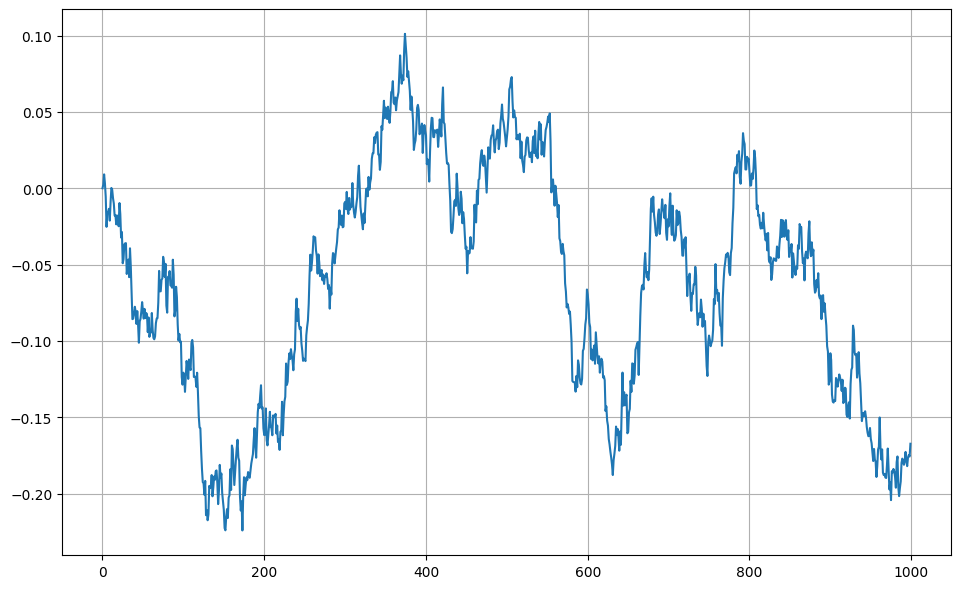

In [387]:
s0 = 0.
lam = 20
theta = 0.
nu = 1.8

x0 = np.array([-0.75] + [0] * (2**(N + 1) - 1)) 

l_OU = (Ø * s0 + _1 * lam * theta + _2 * nu).tensor_prod((-lam * _1).shuffle_exp(12))
x0[1 + l_OU.indices] = l_OU.array.real.flatten()

plt.plot((l_OU @ W_sig).real.flatten())

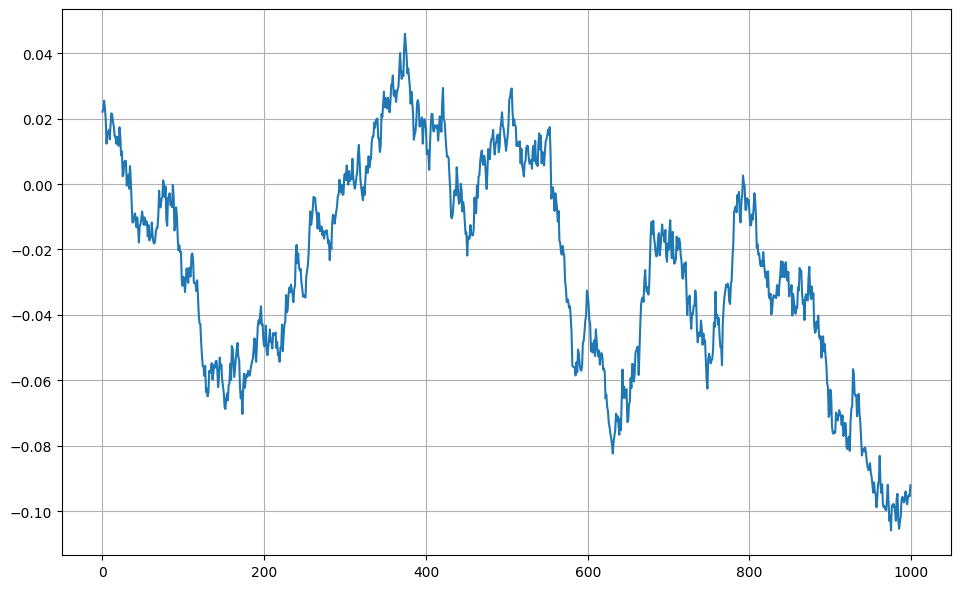

In [679]:
plt.plot((calibration.model.vol_ts @ W_sig).real.flatten())

In [77]:
mc_call_price, mc_call_price_lower, mc_call_price_upper = vanilla_option.get_price(model=calibration.model, method="mc", 
                                                                          F0=calibration.F0, is_vol_surface=False, 
                                                                          pricing_params=MCParams(size=10**7, batch_size=10**4, return_accuracy=True, timestep=0.001))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:00<00:00,  1.51it/s]


In [86]:
from pricing.pricing.volatility_surface.volatility_surface import black_iv

array([[0.8165663 , 0.83139738, 0.83733644, 0.84328901, 0.84628876,
        0.84922887, 0.85516255, 0.86110085, 0.86701065, 0.87296657,
        0.87590933, 0.87889471, 0.88485243, 0.89073503, 0.89374865,
        0.89666822, 0.89964386, 0.90263392, 0.90562043, 0.9085843 ,
        0.91150393, 0.91451038, 0.91747221, 0.92041367, 0.92339796,
        0.92638123, 0.92931403, 0.93227474, 0.9352452 , 0.93823539,
        0.9412046 , 0.94414678, 0.94710902, 0.95009801, 0.95303546,
        0.956038  , 0.95899351, 0.961992  , 0.96491449, 0.96787691,
        0.97086403, 0.9738383 , 0.97677767, 0.97976301, 0.98274088,
        0.9857021 , 0.98865538, 0.99161799, 0.99458951, 0.99756431,
        1.00032415, 1.00345674, 1.00642502, 1.00938839, 1.01235728,
        1.01530994, 1.01828418, 1.02126376, 1.02423176, 1.02719605,
        1.03013517, 1.03310096, 1.03609548, 1.03903714, 1.04201017,
        1.04496422, 1.04792599, 1.05095027, 1.05389099, 1.05681856,
        1.05978179, 1.06278729, 1.06573691, 1.06

In [101]:
vanilla_option.K[:, idx_start:idx_end]

array([[0.89374865, 0.89666822, 0.89964386, 0.90263392, 0.90562043,
        0.9085843 , 0.91150393, 0.91451038, 0.91747221, 0.92041367,
        0.92339796, 0.92638123, 0.92931403, 0.93227474, 0.9352452 ,
        0.93823539, 0.9412046 , 0.94414678, 0.94710902, 0.95009801,
        0.95303546, 0.956038  , 0.95899351, 0.961992  , 0.96491449,
        0.96787691, 0.97086403, 0.9738383 , 0.97677767, 0.97976301,
        0.98274088, 0.9857021 , 0.98865538, 0.99161799, 0.99458951,
        0.99756431, 1.00032415, 1.00345674, 1.00642502, 1.00938839,
        1.01235728, 1.01530994, 1.01828418, 1.02126376, 1.02423176,
        1.02719605, 1.03013517, 1.03310096, 1.03609548, 1.03903714]])

In [137]:
idx_start_call = 24
mc_call_iv = black_iv(mc_call_price, T=vanilla_option.T, K=vanilla_option.K, F=1, r=0, flag="c").squeeze()
mc_call_iv_lower = black_iv(mc_call_price_lower[idx_start_call:], T=vanilla_option.T, K=vanilla_option.K[:, idx_start_call:], F=1, r=0, flag="c").squeeze()
mc_call_iv_upper = black_iv(mc_call_price_upper[idx_start_call:], T=vanilla_option.T, K=vanilla_option.K[:, idx_start_call:], F=1, r=0, flag="c").squeeze()

In [57]:
put_option = VanillaOption(T=vanilla_option.T, K=vanilla_option.K, flag="put")

In [78]:
mc_put_price, mc_put_price_lower, mc_put_price_upper = put_option.get_price(model=calibration.model, method="mc", 
                                                                   F0=calibration.F0, is_vol_surface=False, 
                                                                   pricing_params=MCParams(size=10**7, batch_size=10**4, return_accuracy=True, timestep=0.001))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:19<00:00,  1.47it/s]


In [140]:
idx_start_put = 3

mc_put_iv = black_iv(mc_put_price, T=vanilla_option.T, K=vanilla_option.K, F=1, r=0, flag="p").squeeze()
mc_put_iv_lower = black_iv(mc_put_price_lower[idx_start_put:], T=vanilla_option.T, K=vanilla_option.K[:, idx_start_put:], F=1, r=0, flag="p").squeeze()
mc_put_iv_upper = black_iv(mc_put_price_upper[idx_start_put:], T=vanilla_option.T, K=vanilla_option.K[:, idx_start_put:], F=1, r=0, flag="p").squeeze()

In [74]:
x_rho_pos = x4.copy()
x_rho_pos[0] = -x4[0]
x_rho_pos

[0.702744883,
 0.0221112786,
 -1.72625818,
 0.681061549,
 14.8643526,
 4.33457177,
 -6.87158239,
 0.698257895,
 -111.6646,
 -52.3483094,
 -11.8447579,
 3.72942379,
 -145.851514,
 -13.8284908,
 -7.07060662,
 3.00401415]

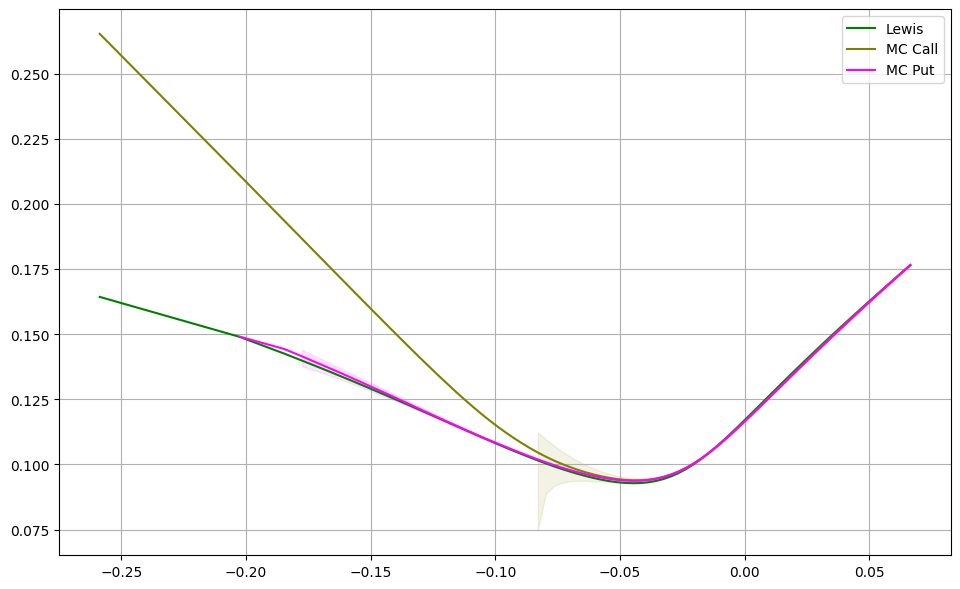

In [146]:
calibration.update_model_parameters(np.array(x_rho_pos))

from dataclasses import asdict


iv = vanilla_option.get_price(
    model=calibration.model,
    method=calibration.calibration_parameters.pricing_method,
    F0=calibration.F0,
    is_vol_surface=True,
    pricing_params=LewisParams(cf_timestep=0.0005, N_points=120, control_variate_sigma=0.13)
    # **asdict(LewisParams(cf_timestep=0.001, N_points=35, control_variate_sigma=0.13))
)

plt.plot(np.log(vanilla_option.K).squeeze(), iv, "g", label="Lewis")
# plt.plot(np.log(vanilla_option.K).squeeze(), md.implied_volatility, "r--", label="mkt")

# plt.plot(np.log(vanilla_option.K).squeeze(), df[df.Expiration == T].iv_bid, "bv", ms=2)
# plt.plot(np.log(vanilla_option.K).squeeze(), df[df.Expiration == T].iv_offer, "bv", ms=2)

plt.plot(np.log(vanilla_option.K).squeeze(), mc_call_iv, "olive", label="MC Call")
plt.fill_between(np.log(vanilla_option.K).squeeze()[idx_start_call:], mc_call_iv_lower, mc_call_iv_upper, color="olive", alpha=0.1)

plt.plot(np.log(vanilla_option.K).squeeze()[1:], mc_put_iv[1:], "magenta", label="MC Put")
plt.fill_between(np.log(vanilla_option.K).squeeze()[idx_start_put:], mc_put_iv_lower, mc_put_iv_upper, color="magenta", alpha=0.1)

plt.legend()

In [148]:
dict_prices = {
    "log_mon": np.log(vanilla_option.K).squeeze(),
    "params": x_rho_pos,
    "mc_call": {
        "iv": mc_call_iv,
        "iv_lower": mc_call_iv_lower,
        "iv_upper": mc_call_iv_upper,
    },
    "mc_put": {
        "iv": mc_put_iv,
        "iv_lower": mc_put_iv_lower,
        "iv_upper": mc_put_iv_upper,
    },
    "lewis": iv
}

In [149]:
name = "N=3_rho_pos"

In [150]:
# dict_res = {}

dict_res[name] = dict_prices

In [151]:
dict_res

{'N=3_rho_neg': {'params': [-0.702744883,
   0.0221112786,
   -1.72625818,
   0.681061549,
   14.8643526,
   4.33457177,
   -6.87158239,
   0.698257895,
   -111.6646,
   -52.3483094,
   -11.8447579,
   3.72942379,
   -145.851514,
   -13.8284908,
   -7.07060662,
   3.00401415],
  'mc_call': {'iv': array([0.30879961, 0.27497663, 0.26308717, 0.25827339, 0.25341878,
          0.25096243, 0.2485449 , 0.24363818, 0.23870477, 0.23376779,
          0.22877195, 0.22629329, 0.22376872, 0.21871369, 0.21369629,
          0.21111716, 0.2086123 , 0.20605383, 0.20347963, 0.2009022 ,
          0.19833717, 0.19580404, 0.19318855, 0.19060621, 0.18803224,
          0.18540964, 0.18278041, 0.18018711, 0.17755972, 0.17491442,
          0.17224417, 0.16958273, 0.16693641, 0.16426092, 0.1615505 ,
          0.15887821, 0.15613765, 0.15342942, 0.15067228, 0.14797313,
          0.14522503, 0.14244401, 0.13966484, 0.1369095 , 0.13410373,
          0.13130129, 0.12851085, 0.12572883, 0.12294761, 0.12017637,
     

import json 

def convert_numpy_to_list(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_numpy_to_list(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_to_list(element) for element in obj]
    else:
        return obj

with open('calibrated_smile_martingality.json', 'w') as f:
    json.dump(convert_numpy_to_list(dict_res), f)